# 1. Estimation of Obesity Levels - Male only

A variation of the Estimation of Obesity script using only the most-relevant features for classifying Male records only.

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from collections import Counter
from scipy.stats import ttest_ind, f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Start script run time
script_start_time = time.time()

In [3]:
def run_time(start_time):
  """
  Calculate run time (hours, minutes, seconds)
  start_time - Start time of script/model
  """

  # End time
  end_time = time.time()

  # Compute run time (hours, minutes, seconds)
  hours = int((end_time - start_time) / 3600)
  minutes = int(((end_time - start_time) % 3600) / 60)
  seconds = int(((end_time - start_time) % 3600) % 60)

  return hours, minutes, seconds

## 2. Data Preprocessing

### 2.1. Load Data

In [4]:
try:
  # Load dataframe (df) into appropriate format
  dataset = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
  print("Data loaded successfully.")
except:
  # No data found
  print("Data not found. Please try again.")
  sys.exit()

Data loaded successfully.


### 2.2. Inital Preprocessing

In [5]:
# Restrict data to Male records only
dataset = dataset[dataset['Gender'] == 'Male']

# Drop gender column
dataset = dataset.drop(columns=['Gender'])

In [6]:
dataset

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
2,23.000000,1.800000,77.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,27.000000,1.800000,87.000000,no,no,3.000000,3.000000,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,22.000000,1.780000,89.800000,no,no,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
5,29.000000,1.620000,53.000000,no,yes,2.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Automobile,Normal_Weight
7,22.000000,1.640000,53.000000,no,no,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,30.642430,1.653876,102.583895,yes,yes,2.919526,2.142328,Sometimes,no,1.175714,no,0.958555,0.636289,no,Public_Transportation,Obesity_Type_II
1795,20.068432,1.657132,105.580491,yes,yes,2.724121,1.437959,Sometimes,no,1.590418,no,0.029603,1.122118,no,Public_Transportation,Obesity_Type_II
1796,20.914366,1.644751,101.067988,yes,yes,2.801992,1.343117,Sometimes,no,1.128942,no,0.233987,0.819980,no,Public_Transportation,Obesity_Type_II
1797,25.512048,1.660761,104.321463,yes,yes,2.748971,1.213431,Sometimes,no,1.448875,no,0.128548,1.239038,no,Public_Transportation,Obesity_Type_II


In [7]:
# Brief info about dataframe - non-null values and datatype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 2 to 1798
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1068 non-null   float64
 1   Height                          1068 non-null   float64
 2   Weight                          1068 non-null   float64
 3   family_history_with_overweight  1068 non-null   object 
 4   FAVC                            1068 non-null   object 
 5   FCVC                            1068 non-null   float64
 6   NCP                             1068 non-null   float64
 7   CAEC                            1068 non-null   object 
 8   SMOKE                           1068 non-null   object 
 9   CH2O                            1068 non-null   float64
 10  SCC                             1068 non-null   object 
 11  FAF                             1068 non-null   float64
 12  TUE                             1068 no

In [8]:
# Check for duplicate records
dataset.duplicated().sum()

np.int64(16)

In [9]:
# Check for missing values
dataset.isnull().sum()

,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0
CH2O,0


In [10]:
# # -- Drop/impute missing data (if required) --

# # Drop rows with missing values
# dataset = dataset.dropna(axis=0, how='any')

# # ['mean', 'median', 'most_frequent', 'constant']
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# imputer.fit_transform(dataset)
# dataset = imputer.transform(dataset)

# dataset.isnull().sum()

In [11]:
# Re-organize dataframe
dataset = dataset[['Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'NObeyesdad']]

In [12]:
# Dataframe statistics on quantitative (numerical) values
dataset.describe(include='all')

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,1068.000000,1068.000000,1068.000000,1068,1068,1068.000000,1068.000000,1068,1068,1068.000000,1068,1068.000000,1068.000000,1068,1068,1068
unique,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,4,5,7
top,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_II
freq,NaN,NaN,NaN,915,966,NaN,NaN,921,1039,NaN,1042,NaN,NaN,690,726,295
mean,24.616020,1.758690,90.769478,NaN,NaN,2.274238,2.737592,NaN,NaN,2.073373,NaN,1.169639,0.668256,NaN,NaN,NaN
std,6.273121,0.072174,21.407030,NaN,NaN,0.477400,0.735382,NaN,NaN,0.584581,NaN,0.830368,0.643032,NaN,NaN,NaN
min,14.000000,1.560000,45.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,20.000000,1.705205,75.000000,NaN,NaN,2.000000,2.658747,NaN,NaN,1.880571,NaN,0.582555,0.000000,NaN,NaN,NaN
50%,23.000000,1.760000,89.945470,NaN,NaN,2.032064,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.601865,NaN,NaN,NaN
75%,27.933529,1.807382,108.460518,NaN,NaN,2.737235,3.000000,NaN,NaN,2.464554,NaN,1.927013,1.000000,NaN,NaN,NaN


## 3. Initial Exploratory Data Analysis (EDA)

In [13]:
# Significance value (alpha) for hypothesis testing
alpha = 0.05

In [14]:
def t_test(a, b, alpha=0.05):
  """
  Perform a two-sample Student's t-Test for Groups a and b
  a     - Group a
  b     - Group b
  alpha - Significance level (e.g: 0.05 -> 0.95 or 95% confidence level)
  """

  # Perform a two-sample t-test
  stat, p = ttest_ind(a, b, equal_var=False, alternative='two-sided')
  print('t-value=%.3f, p-value=%.3f, significance level=%.2f' % (stat, p, alpha))
  # Interpret results
  if (p < alpha):
      print('Reject Null Hypothesis (H0)')
  else:
      print('Fail to Reject Null Hypothesis (H0)')


#### Pairwise relationships between features - Numerical data

<Figure size 300x300 with 0 Axes>

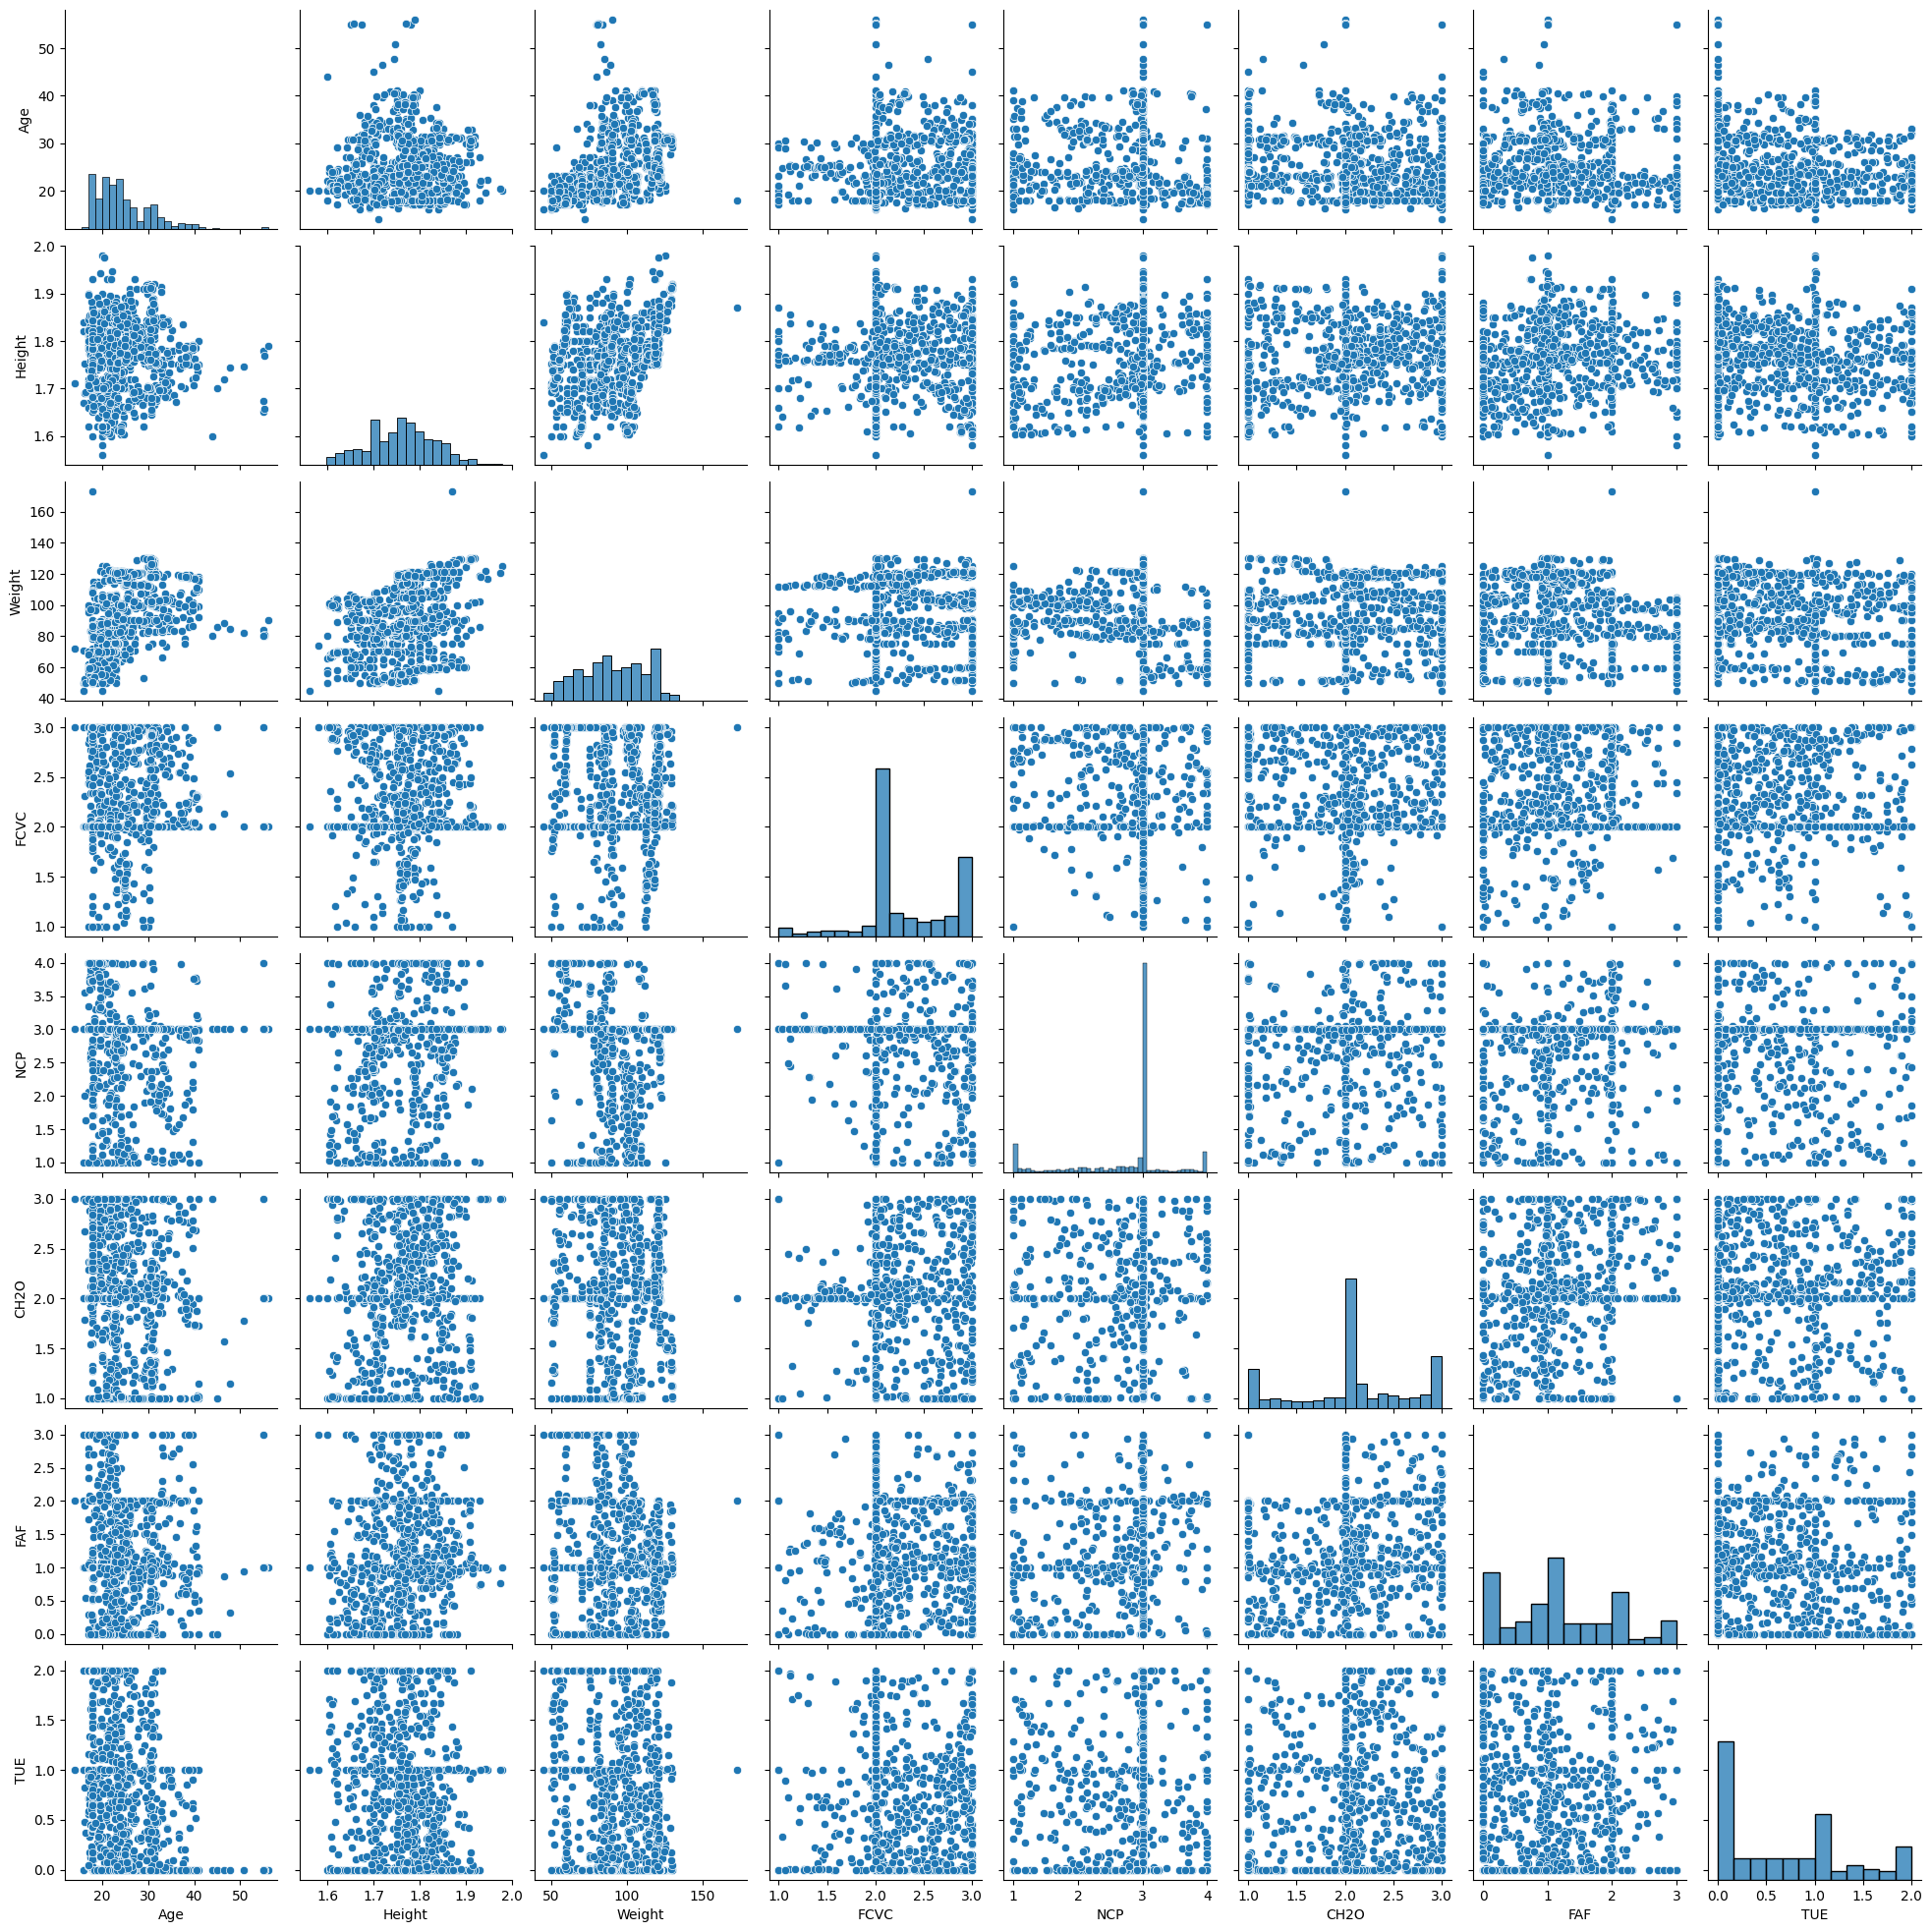

In [15]:
# Define pairplot
plt.figure(figsize=(3,3))

# Pairwise distributions
sns.pairplot(dataset)

# Show figure
plt.show()

#### Correlation Map - Numerical data

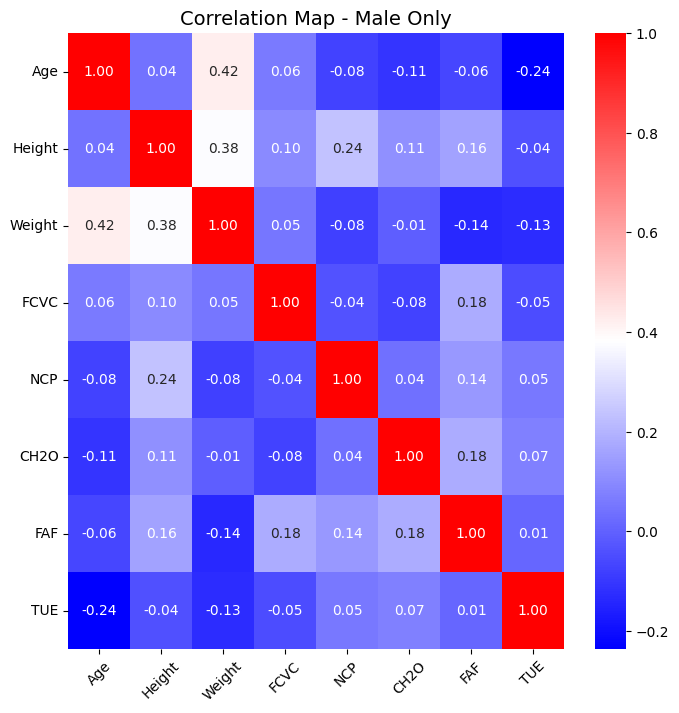

In [16]:
# Define correlation map figure
plt.figure(figsize=(8,8))

# Correlation Map
sns.heatmap(dataset[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].corr(),
            cmap='bwr', annot=True, fmt = ".2f")
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(rotation=0)
# Plot title
plt.title('Correlation Map - Male Only', fontsize=14)

# Show figure
plt.show()

NOTE: For all boxplots, a solid red vertical line represents the mean average value per category.

#### Age distribution

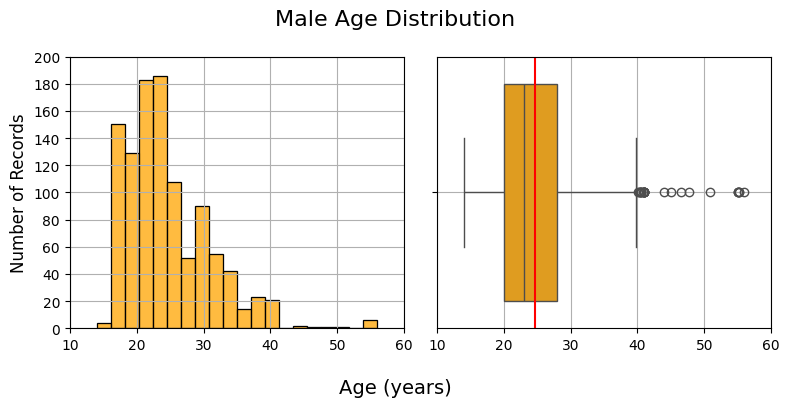

In [17]:
# Define subplot figure
age_dist_1 = plt.figure(figsize=(8,4))

age_dist_1.suptitle('Male Age Distribution', fontsize=16)
age_dist_1.supxlabel('Age (years)', fontsize=14)

# Histogram - Male Age
ax1 = age_dist_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='Age', bins=20, color='orange')
# Adjust axes range(s)
plt.xticks(np.arange(10, 70, 10))
plt.yticks(np.arange(0, 220, 20))
# Plot label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Box plot - Male Age
ax2 = age_dist_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='Age', color='orange')
ax2 = plt.axvline(x=dataset['Age'].mean(), color='red')
# Adjust axes range(s)
plt.xticks(np.arange(10, 70, 10))
# Plot label(s)
plt.xlabel('', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

#### Height distribution

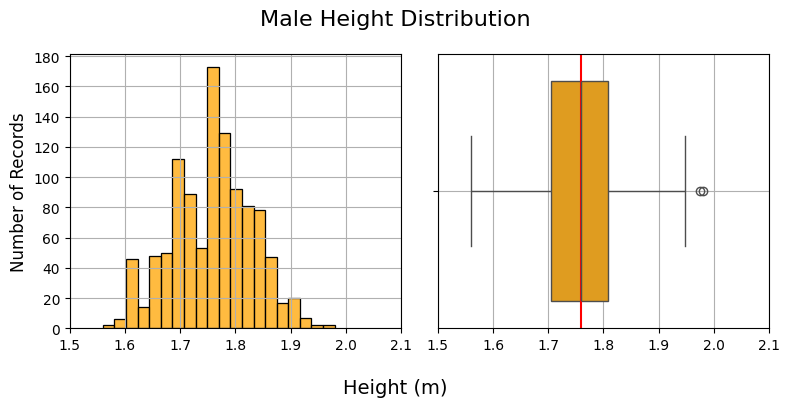

In [18]:
# Define subplot figure
height_dist_1 = plt.figure(figsize=(8,4))

height_dist_1.suptitle('Male Height Distribution', fontsize=16)
height_dist_1.supxlabel('Height (m)', fontsize=14)

# Histogram - Male Height
ax1 = height_dist_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='Height', bins=20, color='orange')
# Adjust axes range(s)
plt.xticks(np.arange(1.5, 2.1, 0.1))
plt.yticks(np.arange(0, 200, 20))
# Plot label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Box plot - Male Height
ax2 = height_dist_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='Height', color='orange')
ax2 = plt.axvline(x=dataset['Height'].mean(), color='red')
# Adjust axes range(s)
plt.xticks(np.arange(1.5, 2.1, 0.1))
# Plot label(s)
plt.xlabel('', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

#### Weight distribution

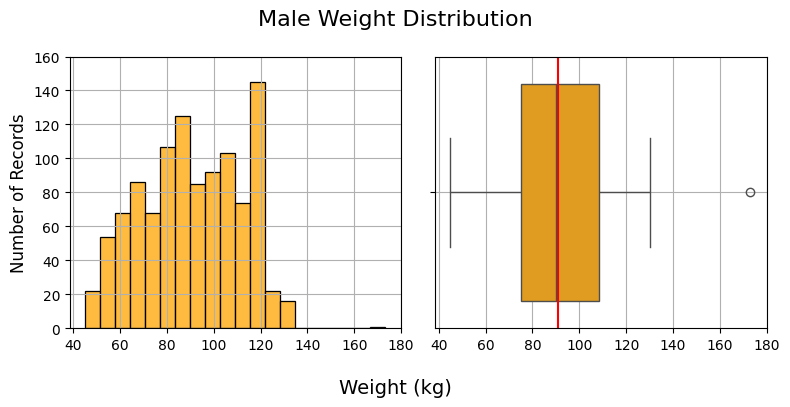

In [19]:
# Define subplot figure
weight_dist_1 = plt.figure(figsize=(8,4))

weight_dist_1.suptitle('Male Weight Distribution', fontsize=16)
weight_dist_1.supxlabel('Weight (kg)', fontsize=14)

# Histogram - Male Weight
ax1 = weight_dist_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='Weight', bins=20, color='orange')
# Adjust axes range(s)
plt.xticks(np.arange(40, 200, 20))
plt.yticks(np.arange(0, 180, 20))
# Plot label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Box plot - Male Weight
ax2 = weight_dist_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='Weight', color='orange')
ax2 = plt.axvline(x=dataset['Weight'].mean(), color='red')
# Adjust axes range(s)
plt.xticks(np.arange(40, 200, 20))
# Plot label(s)
plt.xlabel('', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

#### Has a family member suffered or suffers from overweight?

/tmp/ipython-input-864540906.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  overweight_hist_1 = sns.countplot(data=dataset, x='family_history_with_overweight',


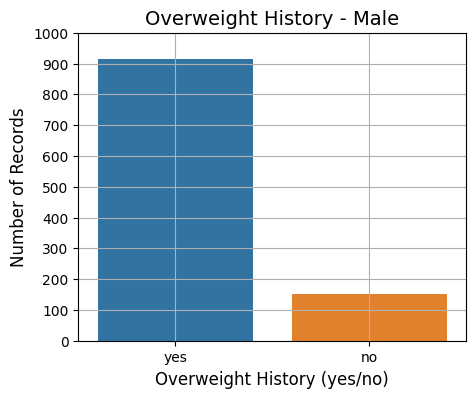

In [20]:
# Define figure
overweight_hist_1 = plt.figure(figsize=(5, 4))

# Overweight History
overweight_hist_1 = sns.countplot(data=dataset, x='family_history_with_overweight',
                                  palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 1100, 100))
# Plot title and label(s)
plt.title('Overweight History - Male', fontsize=14)
plt.xlabel('Overweight History (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Do you eat high caloric food frequently?

/tmp/ipython-input-4269517390.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  high_cal_foods_1 = sns.countplot(data=dataset, x='FAVC', palette='tab10')


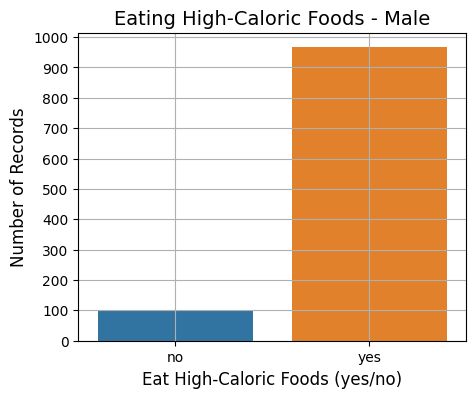

In [21]:
# Define figure
high_cal_foods_1 = plt.figure(figsize=(5,4))

# Eating high-caloric foods
high_cal_foods_1 = sns.countplot(data=dataset, x='FAVC', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 1100, 100))
# Plot title and label(s)
plt.title('Eating High-Caloric Foods - Male', fontsize=14)
plt.xlabel('Eat High-Caloric Foods (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Do you usually eat vegetables in your meals?

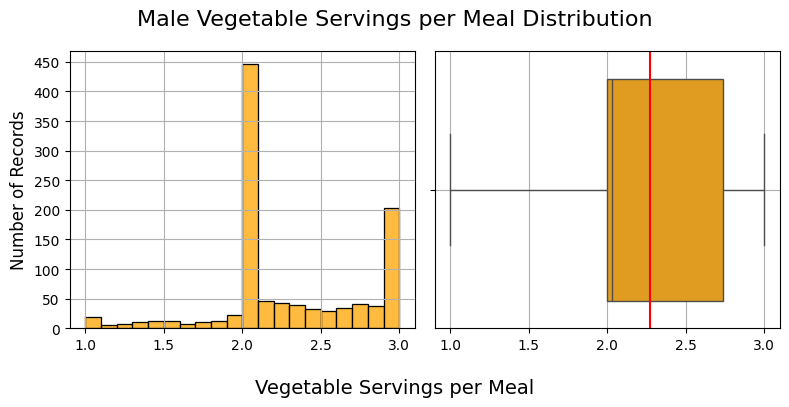

In [22]:
# Define subplot figure
eat_veggies_1 = plt.figure(figsize=(8,4))

eat_veggies_1.suptitle('Male Vegetable Servings per Meal Distribution', fontsize=16)
eat_veggies_1.supxlabel('Vegetable Servings per Meal', fontsize=14)

# Histogram - Male Weight
ax1 = eat_veggies_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='FCVC', bins=20, color='orange')
# Adjust axes range(s)
plt.xticks(np.arange(1, 3.5, 0.5))
plt.yticks(np.arange(0, 500, 50))
# Plot title and label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Box plot - Male Weight
ax2 = eat_veggies_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='FCVC', color='orange')
ax2 = plt.axvline(x=dataset['FCVC'].mean(), color='red')
# Adjust axes range(s)
plt.xticks(np.arange(1, 3.5, 0.5))
# Plot title and label(s)
plt.xlabel('', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

Vegetable Servings per Meal:

1.   Never
2.   Sometimes
3.   Always

#### How many main meals do you have daily?

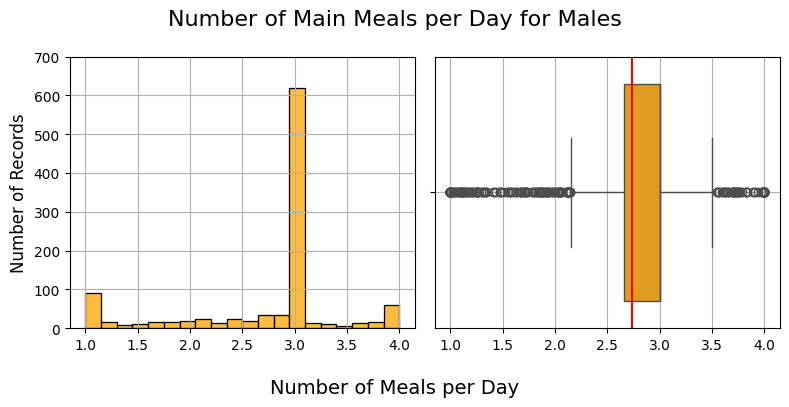

In [23]:
# Define subplot figure
main_meals_1 = plt.figure(figsize=(8,4))

main_meals_1.suptitle('Number of Main Meals per Day for Males', fontsize=16)
main_meals_1.supxlabel('Number of Meals per Day', fontsize=14)

# Main Meals per Day - Histogram
ax1 = main_meals_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='NCP', color='orange', bins=20)
# Adjust Axes range(s)
plt.xticks(np.arange(1, 4.5, 0.5))
plt.yticks(np.arange(0, 800, 100))
# Plot title and label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Main Meals per Day - Boxplot
ax2 = main_meals_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='NCP', color='orange')
ax2 = plt.axvline(x=dataset['NCP'].mean(), color='red')
# Adjust Axes range(s)
plt.xticks(np.arange(1, 4.5, 0.5))
# Plot title and label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

Number of Meals per Day:

1.   Between 1 and 2 meals
2.   3 meals
3.   More than 3 meals

#### How often do you have physical activity?

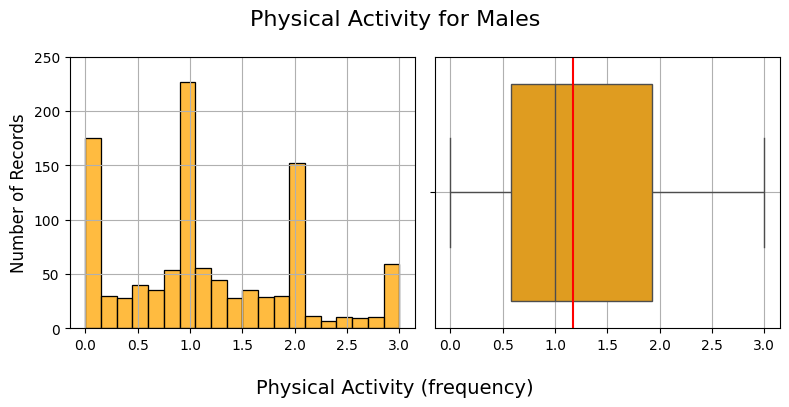

In [24]:
# Define subplot figure
phys_act_1 = plt.figure(figsize=(8,4))

phys_act_1.suptitle('Physical Activity for Males', fontsize=16)
phys_act_1.supxlabel('Physical Activity (frequency)', fontsize=14)

# Main Meals per Day - Histogram
ax1 = phys_act_1.add_subplot(1, 2, 1)
ax1 = sns.histplot(data=dataset, x='FAF', color='orange', bins=20)
# Adjust Axes range(s)
plt.xticks(np.arange(0, 3.5, 0.5))
plt.yticks(np.arange(0, 300, 50))
# Plot title and label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot grid
plt.grid(True)

# Main Meals per Day - Boxplot
ax2 = phys_act_1.add_subplot(1, 2, 2)
ax2 = sns.boxplot(data=dataset, x='FAF', color='orange')
ax2 = plt.axvline(x=dataset['FAF'].mean(), color='red')
# Adjust Axes range(s)
plt.xticks(np.arange(0, 3.5, 0.5))
# Plot title and label(s)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

Physical Activity frequency:

1.   I do not have
2.   1 or 2 days
3.   2 or 4 days
4.   4 or 5 days

#### How often do you drink alcohol?

/tmp/ipython-input-3408892724.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  alcohol_1 = sns.countplot(data=dataset, x='CALC', palette='tab10')


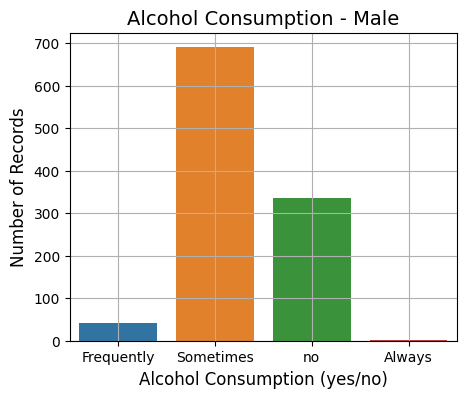

In [25]:
# Define subplot figure
alcohol_1 = plt.figure(figsize=(5,4))

# Alcohol Consumption
alcohol_1 = sns.countplot(data=dataset, x='CALC', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 800, 100))
# Plot title and label(s)
plt.title('Alcohol Consumption - Male', fontsize=14)
plt.xlabel('Alcohol Consumption (yes/no)', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Which transportation do you usually use?

/tmp/ipython-input-3817883389.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  transit_hist_1 = sns.countplot(data=dataset, x='MTRANS', palette='tab10')


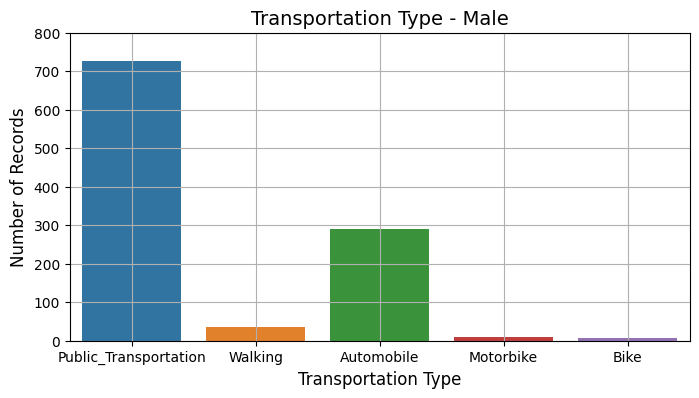

In [26]:
# Define figure
transit_hist_1 = plt.figure(figsize=(8, 4))

# Transportation Type - Male
transit_hist_1 = sns.countplot(data=dataset, x='MTRANS', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 900, 100))
# Plot title and label(s)
plt.title('Transportation Type - Male', fontsize=14)
plt.xlabel('Transportation Type', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

/tmp/ipython-input-2777911118.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  transit_male_1 = sns.violinplot(data=dataset, x='MTRANS', y='Age', palette='tab10')


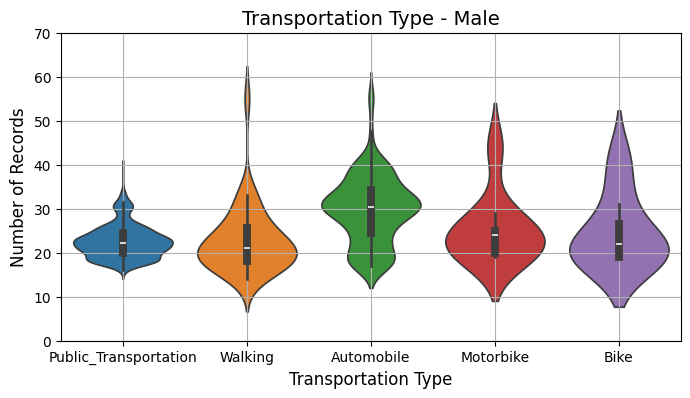

In [27]:
# Define subplot figure
transit_male_1 = plt.figure(figsize=(8, 4))

# Transportation Type - Male - violin plot
transit_male_1 = sns.violinplot(data=dataset, x='MTRANS', y='Age', palette='tab10')
# Adjust Y-Axis axes range(s)
plt.yticks(np.arange(0, 80, 10))
# Plot title and label(s)
plt.title('Transportation Type - Male', fontsize=14)
plt.xlabel('Transportation Type', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Show figure
plt.show()

#### Obesity Level (dependent variable)

In [28]:
obesity_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
                 'Obesity_Type_III']

/tmp/ipython-input-1413674508.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_dist = sns.countplot(data=dataset, x='NObeyesdad', palette='tab10',


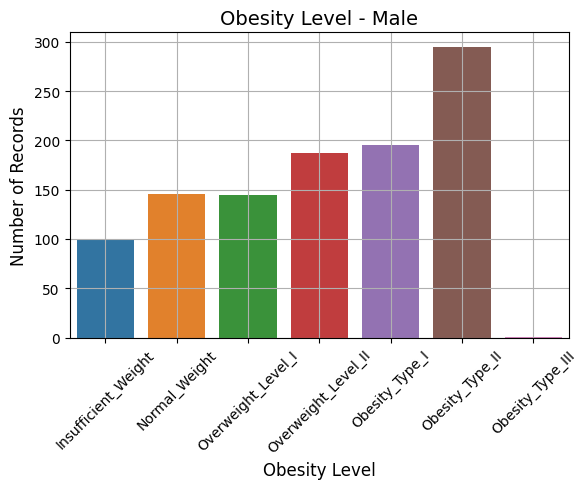

In [29]:
# Define figure
obesity_level_dist = plt.figure(figsize=(6,5))

# Obesity Level - Male
obesity_level_dist = sns.countplot(data=dataset, x='NObeyesdad', palette='tab10',
                                   order=obesity_order, dodge=False)

# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 350, 50))
# Plot title and axes labels
plt.title('Obesity Level - Male', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
# Plot legend and grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

/tmp/ipython-input-43141281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_1 = sns.barplot(data=dataset, x='NObeyesdad', y='Age',


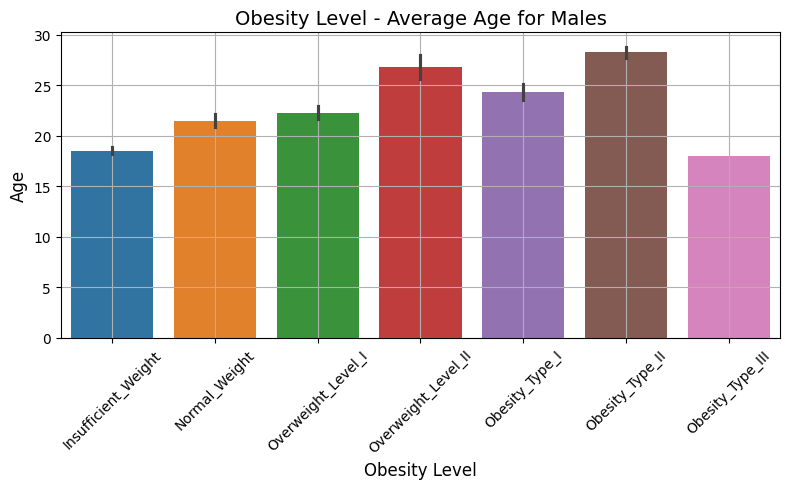

In [30]:
# Define figure
obesity_level_1 = plt.figure(figsize=(8,5))

# Obesity Level - Average age for males
obesity_level_1 = sns.barplot(data=dataset, x='NObeyesdad', y='Age',
                                     palette='tab10', order=obesity_order)
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 35, 5))
# Plot title and axes labels
plt.title('Obesity Level - Average Age for Males', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

*NOTE: Black bar lines refer to a 95% confidence interval.

/tmp/ipython-input-1678287165.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_2 = sns.boxplot(data=dataset, x='NObeyesdad', y='Age',


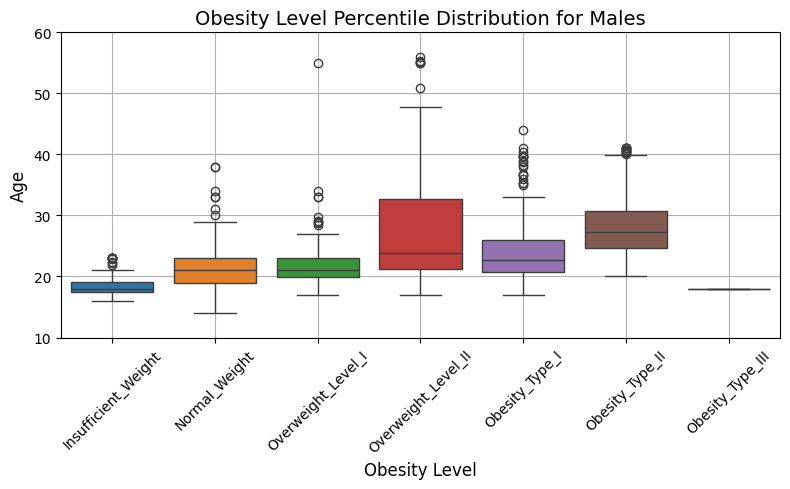

In [31]:
# Define figure
obesity_level_2 = plt.figure(figsize=(8,5))

# Obesity Level - average age for males - percentile distribution
obesity_level_2 = sns.boxplot(data=dataset, x='NObeyesdad', y='Age',
                                     palette='tab10', order=obesity_order)
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(10, 70, 10))
# Plot title and axes labels
plt.title('Obesity Level Percentile Distribution for Males', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

/tmp/ipython-input-25486184.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  obesity_level_male_violin = sns.violinplot(data=dataset, x='NObeyesdad',


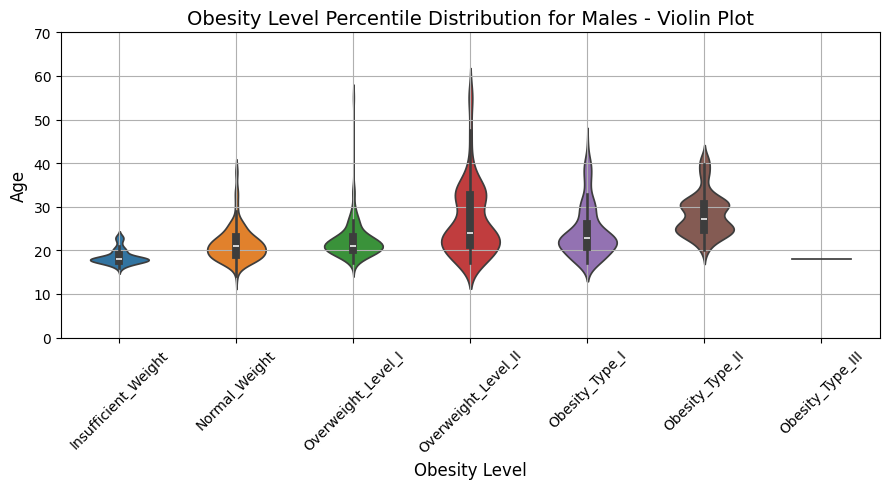

In [32]:
# Define figure
obesity_level_male_violin = plt.figure(figsize=(9,5))

# Obesity Level - average age for males - violin plot
obesity_level_male_violin = sns.violinplot(data=dataset, x='NObeyesdad',
                                             y='Age', width=0.5, palette='tab10',
                                             order=obesity_order)
# Adjust X and Y-Axes
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 80, 10))
# Plot title and axes labels
plt.title('Obesity Level Percentile Distribution for Males - Violin Plot', fontsize=14)
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Age', fontsize=12)
# Plot grid
plt.grid(True)

# Tight layout
plt.tight_layout()

# Show figure
plt.show()

In [33]:
# Perform a one-way ANOVA test for Obesity Level (dependent variable)

# One-way ANOVA test for each obesity level
f_stat, anova_p_value = f_oneway(dataset[dataset['NObeyesdad'] == 'Insufficient_Weight']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Normal_Weight']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Overweight_Level_I']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Overweight_Level_II']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Obesity_Type_I']['Age'],
                                dataset[dataset['NObeyesdad'] == 'Obesity_Type_II']['Age'],
                                # dataset[dataset['NObeyesdad'] == 'Obesity_Type_III']['Age'],
                                equal_var=False
                                )
print("Null Hypothesis (H0)       : No significant difference in average age between obesity levels for males.")
print("Alternative Hypothesis (H1): There is a significant difference in average age between obesity levels for males.")
print("")

# Print and interpret results
print("f-value=%.3f, p-value=%.3f, significance level=%.2f" % (f_stat, anova_p_value, alpha))
if (anova_p_value < alpha):
    print('Reject Null Hypothesis (H0)')
else:
    print('Fail to Reject Null Hypothesis (H0)')

Null Hypothesis (H0)       : No significant difference in average age between obesity levels for males.
Alternative Hypothesis (H1): There is a significant difference in average age between obesity levels for males.

f-value=198.259, p-value=0.000, significance level=0.05
Reject Null Hypothesis (H0)


*NOTE: The single male record for Obesity_Type_III was excluded for the ANOVA test. If included, this would have resulted in an error when calculating both f and p-values.

## 4. Prepare Data for Modelling

### 4.1. Select features

In [34]:
# Re-organize dataframe
df = dataset[[
              'Age',
              'Height',
              'Weight',
              'family_history_with_overweight',
              # 'FAVC',
              # 'FCVC',
              'NCP',
              # 'CAEC',
              # 'SMOKE',
              # 'CH2O',
              # 'SCC',
              'FAF',
              # 'TUE',
              'CALC',
              'MTRANS',
              'NObeyesdad'
            ]]

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 2 to 1798
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1068 non-null   float64
 1   Height                          1068 non-null   float64
 2   Weight                          1068 non-null   float64
 3   family_history_with_overweight  1068 non-null   object 
 4   NCP                             1068 non-null   float64
 5   FAF                             1068 non-null   float64
 6   CALC                            1068 non-null   object 
 7   MTRANS                          1068 non-null   object 
 8   NObeyesdad                      1068 non-null   object 
dtypes: float64(5), object(4)
memory usage: 115.7+ KB


#### Select matrix of features (X) and dependent variable (y)

In [36]:
# Get values for matrix of features (X) and dependent variable (y)
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

print(X.shape, y.shape)

(1068, 8) (1068,)


#### 4.2. Label Encode categorical fields

In [37]:
# All features
le = LabelEncoder()
# le_columns = [0, 3, 4, 7, 8, 10, 13, 14]
le_columns = [0, 3, 6, 7]

# Apply Label Encoding
for i in le_columns:
  X[:, i] = le.fit_transform(X[:, i])

# Label Encode the Dependent Variable
y = le.fit_transform(y)

# Print results
print(X[:, 0:14])
print(y)

[[289 1.8 77.0 ... 2.0 1 3]
 [480 1.8 87.0 ... 2.0 1 4]
 [223 1.78 89.8 ... 0.0 2 3]
 ...
 [149 1.644751 101.067988 ... 0.233987 3 3]
 [422 1.660761 104.321463 ... 0.128548 3 3]
 [475 1.69151 102.59518 ... 0.181324 3 3]]
[1 5 6 ... 3 3 3]


###### Dependent Variable Encoded Labels and Respective Classes:

0.   Insufficent Weight
1.   Normal Weight
2.   Obesity Type I
3.   Obesity Type II
4.   Obesity Type III
5.   Overweight Level I
6.   Overweight Level II

### 4.3. Split dataset into training and test sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(854, 8) (854,)
(214, 8) (214,)


### 4.4. Count number of records per dependent variable category

In [39]:
# Unique dependent variable labels (categories/classes)
set_y = np.unique(y_test)
set_y

array([0, 1, 2, 3, 4, 5, 6])

In [40]:
# Create Pandas dataframe for record counting
num_records = [[0, 'Insufficient_Weight'],
              [1, 'Normal_Weight'],
              [2, 'Obesity_Type_I'],
              [3, 'Obesity_Type_II'],
              [4, 'Obesity_Type_III'],
              [5, 'Overweight_I'],
              [6, 'Overweight_II']]
df_num_records = pd.DataFrame(num_records, columns=['Label', 'Category'])
# Count total number of records per category in test dataset (y_test)
y_test_records = dict(Counter(y_test).items())
y_test_records = dict(sorted(y_test_records.items()))

# Convert all observations to Pandas dataframe
df_num_records_values = pd.DataFrame(y_test_records.values(), columns=['Total'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, df_num_records_values], axis=1)

df_num_records

,Label,Category,Total
0,0,Insufficient_Weight,20
1,1,Normal_Weight,23
2,2,Obesity_Type_I,44
3,3,Obesity_Type_II,53
4,4,Obesity_Type_III,1
5,5,Overweight_I,31
6,6,Overweight_II,42


### 4.5. Feature Scaling

In [41]:
# Perform Standardization (compute z-score)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 5. Build and Evaluate Machine Learning Models

In [42]:
# Logistic Regression (LR)
from sklearn.linear_model import LogisticRegression
# K-Nearest Neighbours (KNN)
from sklearn.neighbors import KNeighborsClassifier
# Support Vector Machine - Classification (SVC)
from sklearn.svm import SVC
# Decision Tree (DT)
from sklearn.tree import DecisionTreeClassifier
# Random Forest (RF)
from sklearn.ensemble import RandomForestClassifier
# XGBoost (XGB)
import xgboost as xgb
from xgboost import XGBClassifier
# LightGBM (LGB)
import lightgbm as lgb
from lightgbm import LGBMClassifier
# Deep Neural Network (DNN)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Additional Libraries
import shap
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [43]:
# Plot confusion matrix
def plot_confusion_matrix(model, X_text=X_test, y_test=y_test):
  """
  model  - ML model, predicted results
  X_test - Matrix of features for test set
  y_test - Dependent (target) variable for test set
  """

  # Define confusion matrix figure
  cm = plt.figure(figsize=(7,7))

  # Plot the confusion matrix as heatmap
  cm = confusion_matrix(model, y_test)
  sns.heatmap(cm, annot=True)
  # Get number of predicted records per class (category)
  diag = cm.diagonal()
  # Plot title and axes labels
  plt.title('Confusion Matrix', fontsize=14)
  plt.xlabel('Actual Class', fontsize=12)
  plt.ylabel('Predicted Class', fontsize=12)

  # Return figure - to show
  return cm, diag

In [44]:
# Plot ROC curve
def plot_roc_curve(model, y_test, colour):
  """
  model  - Prediction model
  y_test - Dependent variable (test set)
  colour - Plot colour
  """

  # Define figure
  fig = plt.figure(figsize=(5,5))

  # fpr - False Positive Rate
  # tpr - True Positive Rate
  fpr, tpr, _ = roc_curve(y_test, model)
  # auc - Area Under Curve
  auc = roc_auc_score(y_test, model)
  fig = plt.plot(fpr, tpr, color=colour, label="FPR vs. TPR., AUC: " + str(auc))
  # Plot title and labels
  plt.xlabel("False Positive Rate (FPR)", fontsize=12)
  plt.ylabel("True Positive Rate (TPR)", fontsize=12)
  plt.title("ROC Curve", fontsize=14)
  # Plot legend and grid
  plt.legend(loc="lower right")
  plt.grid(True)

  return fig

In [45]:
# Apply k-Fold Cross Validation on the training set
def k_fold(model, n=10):
  """
  model - Machine Learning model implemented
  n     - number of k-Folds (default 10)
  """

  # Accuracy Scoring
  accuracy_means, accuracy_stds, accuracy_mins, accuracy_maxs = [], [], [], []
  # Cross validate for n k-folds (RepeatedStratifiedKFold - 3 repeats each)
  for i in range(2, 2+n):
    cv = RepeatedStratifiedKFold(n_splits=i, n_repeats=3, random_state=42)
    # Collect appropriate metric results per k-Fold
    accuracy_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

    # Force scores to be positive
    accuracy_scores = abs(accuracy_scores)

    # Append Accuracy scores
    accuracy_means.append(np.mean(accuracy_scores))
    accuracy_stds.append(np.std(accuracy_scores))
    accuracy_mins.append(np.min(accuracy_scores))
    accuracy_maxs.append(np.max(accuracy_scores))

  # Define subplot figure
  k_fold_results = plt.figure(figsize=(9, 4))
  k_fold_results.suptitle('k-Fold Cross Validation Results', fontsize=14)
  k_fold_results.supxlabel('k-Fold', fontsize=12)

  # Plot Accuracy scores per k-fold:
  ax1 = k_fold_results.add_subplot(1, 2, 1)
  ax1.plot(np.arange(1,1+n), accuracy_means, color='red')
  # Adjust X-Axis range
  plt.xticks(np.arange(0, 11, 1))
  # Plot title and label(s)
  ax1.set_ylabel('Accuracy ', fontsize=12)
  ax1.set_title('Accuracy per k-Fold', fontsize=14)
  # Plot grid
  ax1.grid(True)

  # Plot Accuracy Standard Deviations per k-fold:
  ax2 = k_fold_results.add_subplot(1, 2, 2)
  ax2.plot(np.arange(1,1+n), accuracy_stds, color='red')
  # Adjust X-Axis range
  plt.xticks(np.arange(0, 11, 1))
  # Plot title and label(s)
  ax2.set_ylabel('Standard Deviation', fontsize=12)
  ax2.set_title('Accuracy Standard Deviation per k-Fold', fontsize=14)
  # Plot grid
  ax2.grid(True)

  # Tight layout
  plt.tight_layout()

  # Show subplot
  plt.show()

  # Return cv for Grid Searching hyperparameter tuning (optimization)
  return cv

### 5.1. Machine Learning (ML) Models

*NOTE: In order to minimize script run-time

- All SHAP value results per model was commented out. Please refer to the README file for the most-relevant features.
- For each model (except KNN), the optimal hyperparameter values were already implemented.

#### 5.1.1. K-Nearest Neighbours (KNN)

In [46]:
# Start KNN model run time
knn_start_time = time.time()

In [47]:
# Identify optimal hyperparameters via GridSearch
knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=10)

In [48]:
# Define KNN model
# knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf = make_pipeline(knn_grid)

# Train KNN model
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10]}))])

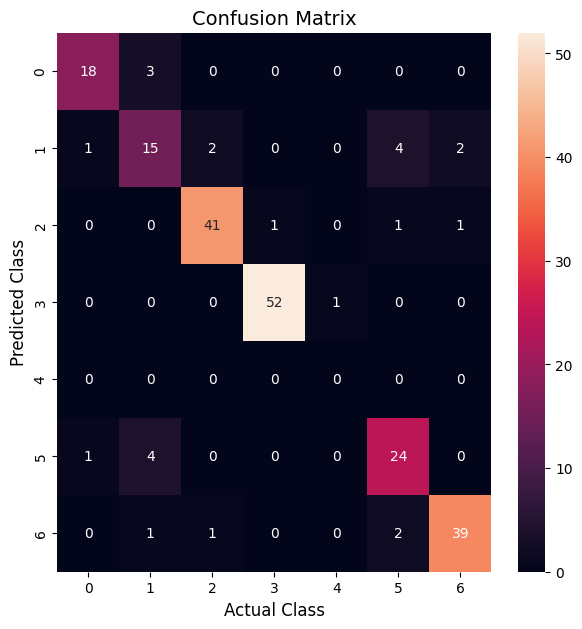


Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.62      0.65      0.64        23
           2       0.93      0.93      0.93        44
           3       0.98      0.98      0.98        53
           4       0.00      0.00      0.00         1
           5       0.83      0.77      0.80        31
           6       0.91      0.93      0.92        42

    accuracy                           0.88       214
   macro avg       0.73      0.74      0.74       214
weighted avg       0.88      0.88      0.88       214



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
# Predict KNN results
knn_pred = knn_clf.predict(X_test)

# print('dt_pred: y_test:')
# print(np.concatenate((dt_pred.reshape(len(dt_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
# print('')

# Plot the confusion matrix
knn_cm, knn_records = plot_confusion_matrix(knn_pred, X_test, y_test)
plt.show()

# TP - True Positive
# TN - True Negative
# FP - False Positive (Type I Error)
# FN - False Negative (Type II Error)

# accuracy = (TP + TN)/(TN + FP + FN + TP)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
# f1_score = (2 * precision * recall)/(precision + recall)
# support = Number of records of each class in predicted model

# Print Classification Report (brief summary of results)
print('')
print('Classification Report: ')
print(classification_report(y_test, knn_pred))

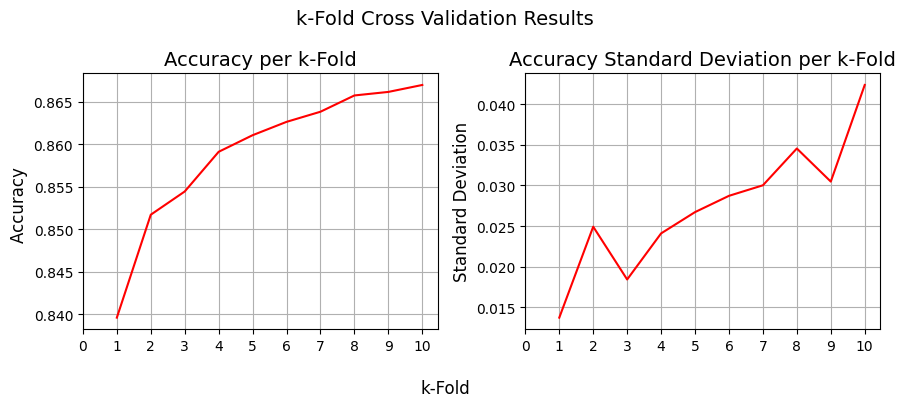

RepeatedStratifiedKFold(n_repeats=3, n_splits=11, random_state=42)

In [50]:
# Perform k-Fold Cross Validation
k_fold(knn_clf, 10)

In [51]:
# Count number of records in KNN predictions per category

# Add values to list
knn_records_list = pd.DataFrame(knn_records, columns=['KNN'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, knn_records_list], axis=1)

df_num_records

,Label,Category,Total,KNN
0,0,Insufficient_Weight,20,18
1,1,Normal_Weight,23,15
2,2,Obesity_Type_I,44,41
3,3,Obesity_Type_II,53,52
4,4,Obesity_Type_III,1,0
5,5,Overweight_I,31,24
6,6,Overweight_II,42,39


In [52]:
# # KNN SHAP Value
# knn_explainer = shap.KernelExplainer(knn_clf.predict, shap.kmeans(X_train, 50))
# knn_shap_values = knn_explainer.shap_values(X_test)

# # Plot SHAP values per feature
# knn_shap_plot = shap.summary_plot(knn_shap_values, X_test)

# # Show plot
# plt.show()

Important Features:

- Height, Alcohol Consumption, Overweight History, Age, Main Meals per Day, Transportation Mode

In [53]:
# Calculate KNN model run time
knn_hours, knn_minutes, knn_seconds = run_time(knn_start_time)
print('KNN run time (h:mm:ss): ' + str(knn_hours) + ':' + str(knn_minutes) +
      ':' + str(knn_seconds))

KNN run time (h:mm:ss): 0:1:29


#### 5.1.2. Support Vector Machine - Classification (SVC)

In [54]:
# Start SVC model run time
svc_start_time = time.time()

In [55]:
# Identify optimal hyperparameters via GridSearch
svc_params = {'kernel': ['linear'],
              'C' : [100],
              # 'C' : [10, 100]
              }

svc_grid = GridSearchCV(SVC(), svc_params, cv=10)

In [56]:
# Define SVC model
svc_clf = SVC(kernel='linear', C=100)
# svc_clf = make_pipeline(svc_grid)

# Train SVC model
svc_clf.fit(X_train, y_train)

SVC(C=100, kernel='linear')

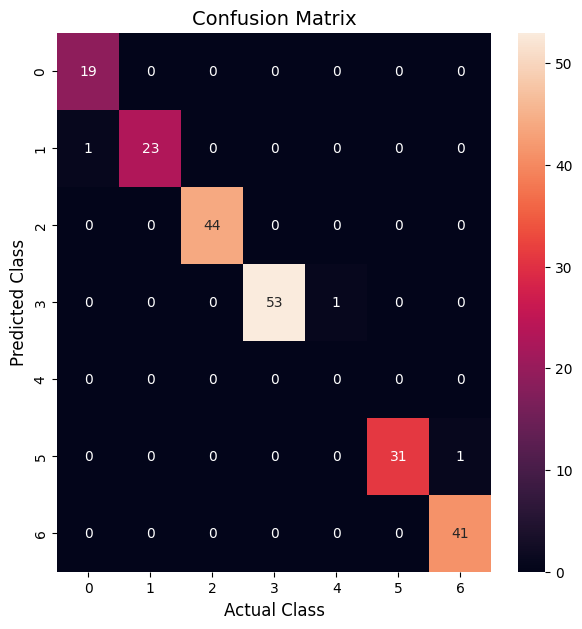


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.96      1.00      0.98        23
           2       1.00      1.00      1.00        44
           3       0.98      1.00      0.99        53
           4       0.00      0.00      0.00         1
           5       0.97      1.00      0.98        31
           6       1.00      0.98      0.99        42

    accuracy                           0.99       214
   macro avg       0.84      0.85      0.85       214
weighted avg       0.98      0.99      0.98       214



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
# Predict SVC results
svc_pred = svc_clf.predict(X_test)

# print('dt_pred: y_test:')
# print(np.concatenate((dt_pred.reshape(len(svc_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
# print('')

# Plot the confusion matrix
svc_cm, svc_records = plot_confusion_matrix(svc_pred, X_test, y_test)
plt.show()

# TP - True Positive
# TN - True Negative
# FP - False Positive (Type I Error)
# FN - False Negative (Type II Error)

# accuracy = (TP + TN)/(TN + FP + FN + TP)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
# f1_score = (2 * precision * recall)/(precision + recall)
# support = Number of records of each class in predicted model

# Print Classification Report (brief summary of results)
print('')
print('Classification Report: ')
print(classification_report(y_test, svc_pred))

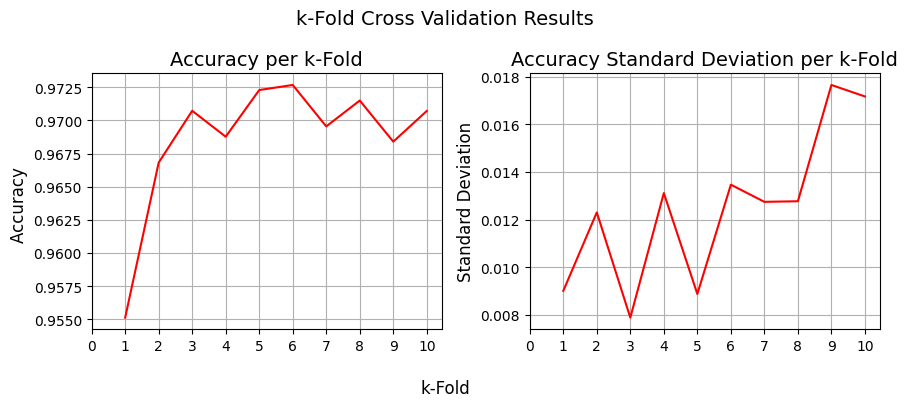

RepeatedStratifiedKFold(n_repeats=3, n_splits=11, random_state=42)

In [58]:
# Perform k-Fold Cross Validation
k_fold(svc_clf, 10)

In [59]:
# Count number of records in SVC predictions per category

# Add values to list
svc_records_list = pd.DataFrame(svc_records, columns=['SVC'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, svc_records_list], axis=1)

df_num_records

,Label,Category,Total,KNN,SVC
0,0,Insufficient_Weight,20,18,19
1,1,Normal_Weight,23,15,23
2,2,Obesity_Type_I,44,41,44
3,3,Obesity_Type_II,53,52,53
4,4,Obesity_Type_III,1,0,0
5,5,Overweight_I,31,24,31
6,6,Overweight_II,42,39,41


In [60]:
# # SVC SHAP Values
# svc_shap_explainer = shap.KernelExplainer(svc_clf.predict, shap.kmeans(X_train, 50))
# svc_shap_values = svc_shap_explainer.shap_values(X_test)

# # Plot SHAP values per feature
# svc_shap_plot = shap.summary_plot(svc_shap_values, X_test)

# # Show plot
# plt.show()

Important Features:

- Weight, Height, Alcohol Consumption, Age, Physical Activity

In [61]:
# Calculate SVC model run time
svc_hours, svc_minutes, svc_seconds = run_time(svc_start_time)
print('SVC run time (h:mm:ss): ' + str(svc_hours) + ':' + str(svc_minutes) +
      ':' + str(svc_seconds))

SVC run time (h:mm:ss): 0:0:8


#### 5.1.3. Random Forest (RF)

In [62]:
# Start RF model run time
rf_start_time = time.time()

In [63]:
# Identify optimal hyperparameters via GridSearch
rf_params = {'random_state': [42],
             'n_estimators': [100, 150, 200, 250],
             'max_depth': [2, 4, 6, 8, 10]}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=10)

In [64]:
# Define RF model
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_clf = make_pipeline(rf_grid)

# Train RF model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

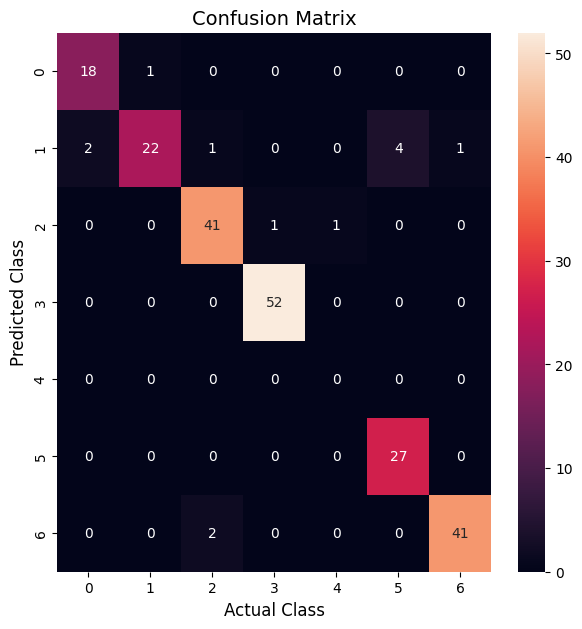


Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.73      0.96      0.83        23
           2       0.95      0.93      0.94        44
           3       1.00      0.98      0.99        53
           4       0.00      0.00      0.00         1
           5       1.00      0.87      0.93        31
           6       0.95      0.98      0.96        42

    accuracy                           0.94       214
   macro avg       0.80      0.80      0.80       214
weighted avg       0.94      0.94      0.94       214



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
# Predict RF results
rf_pred = rf_clf.predict(X_test)

# print('rf_pred: y_test:')
# print(np.concatenate((rf_pred.reshape(len(rf_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
# print('')

# Plot the confusion matrix
rf_cm, rf_records = plot_confusion_matrix(rf_pred, X_test, y_test)
plt.show()

# TP - True Positive
# TN - True Negative
# FP - False Positive (Type I Error)
# FN - False Negative (Type II Error)

# accuracy = (TP + TN)/(TN + FP + FN + TP)
# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
# f1_score = (2 * precision * recall)/(precision + recall)
# support = Number of records of each class in predicted model

# Print Classification Report (brief summary of results)
print('')
print('Classification Report: ')
print(classification_report(y_test, rf_pred))

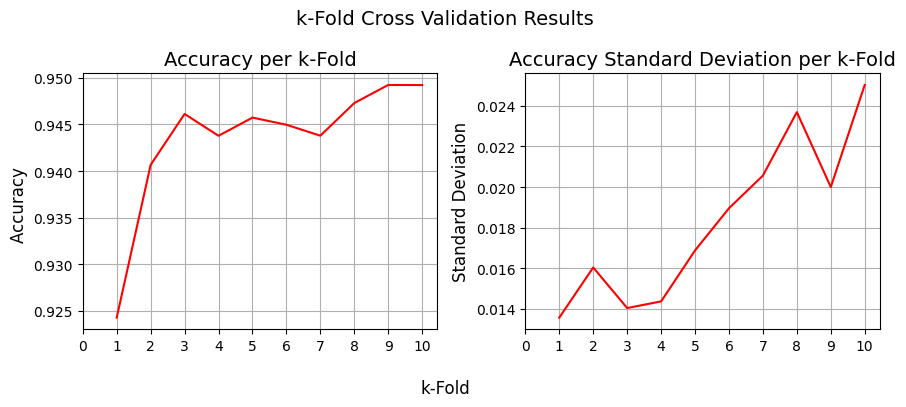

RepeatedStratifiedKFold(n_repeats=3, n_splits=11, random_state=42)

In [66]:
# Perform k-Fold Cross Validation
k_fold(rf_clf, 10)

In [67]:
# Count number of records in RF predictions per category

# Add values to list
rf_records_list = pd.DataFrame(rf_records, columns=['RF'])
# Concatenate with records dataframe
df_num_records = pd.concat([df_num_records, rf_records_list], axis=1)

df_num_records

,Label,Category,Total,KNN,SVC,RF
0,0,Insufficient_Weight,20,18,19,18
1,1,Normal_Weight,23,15,23,22
2,2,Obesity_Type_I,44,41,44,41
3,3,Obesity_Type_II,53,52,53,52
4,4,Obesity_Type_III,1,0,0,0
5,5,Overweight_I,31,24,31,27
6,6,Overweight_II,42,39,41,41


In [68]:
# # RF SHAP Values
# rf_shap_explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 50))
# rf_shap_values = rf_shap_explainer.shap_values(X_test)

# # Plot SHAP values per feature
# rf_shap_plot = shap.summary_plot(rf_shap_values, X_test)

# # Show plot
# plt.show()

Important Features:

- Height, Age, Weight, Alcohol Consumption, Main Meals per Day, Alcohol Consumption

In [69]:
# Calculate RF model run time
rf_hours, rf_minutes, rf_seconds = run_time(rf_start_time)
print('RF run time (h:mm:ss): ' + str(rf_hours) + ':' + str(rf_minutes) +
      ':' + str(rf_seconds))

RF run time (h:mm:ss): 0:0:54


### 5.2. Calculate Model Run-Times and Classification Results

In [70]:
print("Model Run-Times (h:mm:ss) and Accuracy results: \n")

# KNN
print('KNN - ' + str(knn_hours) + ':' + str(knn_minutes) + ':' + str(knn_seconds)
  + ", Accuracy: " + str(round(accuracy_score(y_test, knn_pred)*100, 2)) + "%")
# SVC
print('SVC - ' + str(svc_hours) + ':' + str(svc_minutes) + ':' + str(svc_seconds)
  + ", Accuracy: " + str(round(accuracy_score(y_test, svc_pred)*100, 2)) + "%")
# RF
print('RF - ' + str(rf_hours) + ':' + str(rf_minutes) + ':' + str(rf_seconds)
  + ", Accuracy: " + str(round(accuracy_score(y_test, rf_pred)*100, 2)) + "%")

Model Run-Times (h:mm:ss) and Accuracy results: 

KNN - 0:1:29, Accuracy: 88.32%
SVC - 0:0:8, Accuracy: 98.6%
RF - 0:0:54, Accuracy: 93.93%


In [71]:
# Results per each model
df_num_records

,Label,Category,Total,KNN,SVC,RF
0,0,Insufficient_Weight,20,18,19,18
1,1,Normal_Weight,23,15,23,22
2,2,Obesity_Type_I,44,41,44,41
3,3,Obesity_Type_II,53,52,53,52
4,4,Obesity_Type_III,1,0,0,0
5,5,Overweight_I,31,24,31,27
6,6,Overweight_II,42,39,41,41


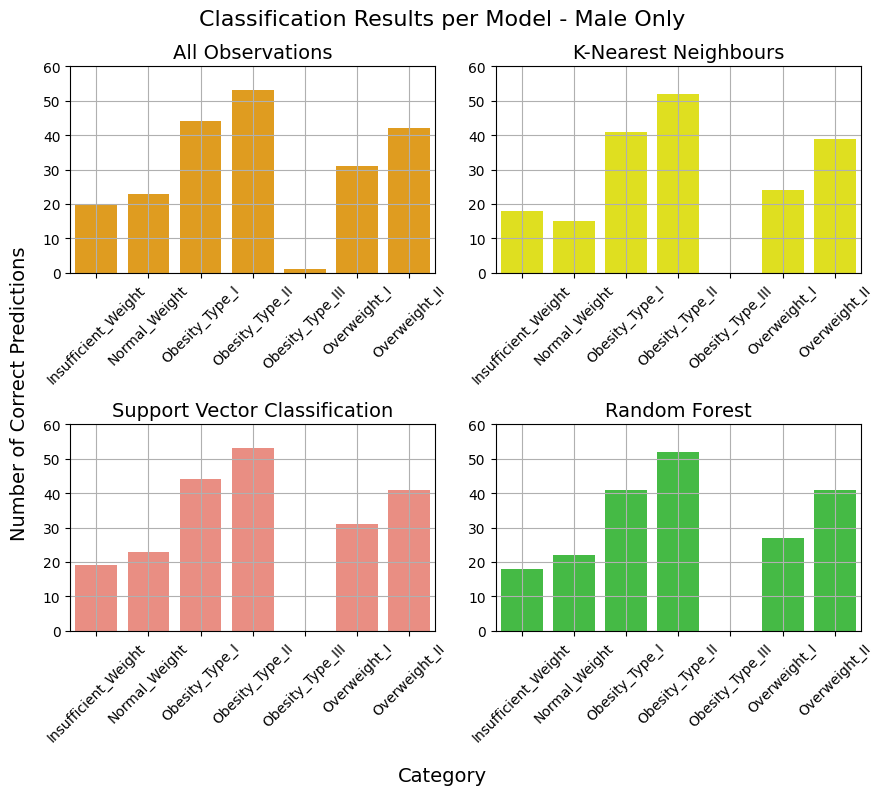

In [72]:
# Plot results
clf_model_results = plt.figure(figsize=(9, 8))

# Overall title and labels
clf_model_results.suptitle('Classification Results per Model - Male Only', fontsize=16)
clf_model_results.supxlabel('Category', fontsize=14)
clf_model_results.supylabel('Number of Correct Predictions', fontsize=14)

# All Categories
ax1 = clf_model_results.add_subplot(2, 2, 1)
ax1 = sns.barplot(data=df_num_records, x='Category', y='Total', color='orange')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 70, 10))
# Plot title and grid
plt.title("All Observations", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Correct predictions - KNN model
ax2 = clf_model_results.add_subplot(2, 2, 2)
ax2 = sns.barplot(data=df_num_records, x='Category', y='KNN', color='yellow')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 70, 10))
# Plot title and grid
plt.title("K-Nearest Neighbours", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Correct predictions - SVC model
ax3 = clf_model_results.add_subplot(2, 2, 3)
ax3 = sns.barplot(data=df_num_records, x='Category', y='SVC', color='salmon')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 70, 10))
# Plot title and grid
plt.title("Support Vector Classification", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Correct predictions - RF model
ax4 = clf_model_results.add_subplot(2, 2, 4)
ax4 = sns.barplot(data=df_num_records, x='Category', y='RF', color='limegreen')
# Adjust X-Axis labels
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 70, 10))
# Plot title and grid
plt.title("Random Forest", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(True)

# Tight layout
plt.tight_layout()

plt.show()

### Calculate Script Run-Time

In [73]:
# Calculate script run time
script_hours, script_minutes, script_seconds = run_time(script_start_time)
print('Script run time (h:mm:ss): ' + str(script_hours) + ':' + str(script_minutes)
  + ':' + str(script_seconds))

Script run time (h:mm:ss): 0:3:4
